In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

sys.path.append(r"../")
from data_loader import ctb_data_loader
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from catboost import CatBoostRegressor

from datetime import datetime

In [2]:
IS_CUSTOM = False
USE_VALID = False
DROPS = [
    'assessmentItemID','testId','Timestamp','year','day','minute','second',
    # 'userID',
    # 'KnowledgeTag',
    
    # 'userAnswerRate',
    # 'tagAnswerRate',
    # 'itemAnswerRate',
    # 'testAnswerRate',
    # 'timeConcentrationRate',
    # 'monthAnswerRate',

    # 'userSolvedLen',
    # 'testSolvedLen',
    # 'tagSolvedLen',
    # 'itemSolvedLen',
    # 'timeConcentrationCount',
    # 'monthSolvedCount',

    # 'userSolvedSum',
    # 'itemSolvedSum',
    # 'testSolvedSum',
    # 'tagSolvedSum',
    # 'timeConcentraionSum',
    # 'monthSolvedSum',

    # 'testSolvedVar',
    # 'userSolvedVar',
    # 'tagSolvedVar',
    # 'itemSolvedVar',
    # 'timeConcentrationVar',
    # 'monthSolvedVar',

    # 'timeConcentrationLevel',

    # 'month',
    # 'hour',

    # 'first3',
    # 'mid3',
    # 'last3',

    # 'user_correct_answer',
    # 'user_total_answer',
    # 'user_acc',
    ]

# CTB preprocessing

In [3]:
x_train, x_valid, y_train, y_valid, test = ctb_data_loader(IS_CUSTOM=IS_CUSTOM, USE_VALID=USE_VALID, DROPS=DROPS)
cat_features = x_train.columns[x_train.nunique()<200].to_list()

/opt/ml/input/code/Boosting/../data_loader.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].fillna(-1).astype(str)


# CatBoostRegressor

In [4]:
model = CatBoostRegressor(cat_features=cat_features, task_type="GPU", leaf_estimation_iterations=10, od_type="Iter", logging_level="Silent")
# , logging_level="Silent","Info"
if USE_VALID:
    model = CatBoostRegressor(cat_features=cat_features, task_type="GPU", use_best_model=True, leaf_estimation_iterations=10, od_type="Iter", early_stopping_rounds=100, logging_level="Silent")

predict = None
param_grid = {
        'iterations': [200],
        'depth': [10],
        'learning_rate': [0.1],
        # 'custom_loss': ['TotalF1'],
        # 'eval_metric': ['TotalF1'],
        # 'random_seed': [42],
        # 'min_data_in_leaf': [3,4,5],
        # 'max_leaves': [200],
        # 'l2_leaf_reg': [100],
        # 'border_count': [100],
        # 'bagging_temperature': [500],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv = KFold(n_splits=6, random_state=42, shuffle=True)

gcv = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=1,
    pre_dispatch=8,
    # verbose=1,
)

In [5]:
show=False
if USE_VALID:
    gcv.fit(x_train, y_train, eval_set=[(x_valid, y_valid)],plot=show, verbose=show)
else:
    gcv.fit(x_train, y_train,plot=show, verbose=show)
# , verbose=2, silent=False
print("final params", gcv.best_params_)
print("best score", gcv.best_score_)

final params {'depth': 10, 'iterations': 200, 'learning_rate': 0.1}
best score 0.8206838364783631


In [6]:
# SAVE OUTPUT
model = gcv.best_estimator_
sub = pd.read_csv("/opt/ml/input/data/sample_submission.csv")
sub["prediction"] = model.predict(test.drop("answerCode", axis=1))

output_dir = "./output/"
now = datetime.now()
now_str = "{:%Y-%m-%d_%H:%M:%S}".format(now)
file_name = f"CTB_R_grid_kfold_custom_submission_{now_str}.csv"
write_path = os.path.join(output_dir, file_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(sub["prediction"]):
        w.write("{},{}\n".format(id, p))

writing prediction : ./output/CTB_R_grid_kfold_custom_submission_2022-11-28_12:03:32.csv


In [7]:
def get_accuracy(PRED_PATH=file_name):
    threshold = 0.5
    ANSWER_PATH = "../../data/custom_answer.csv"

    submission_result = pd.read_csv(PRED_PATH)
    answer = pd.read_csv(ANSWER_PATH)

    y_pred, y = submission_result["prediction"], answer["prediction"]

    return f"accuracy_score: {accuracy_score(y,y_pred.apply(lambda x: 1 if x > threshold else 0))}\nroc  auc_score: {roc_auc_score(y,y_pred)}"

In [8]:
if IS_CUSTOM:
    print(get_accuracy("output/" + file_name))


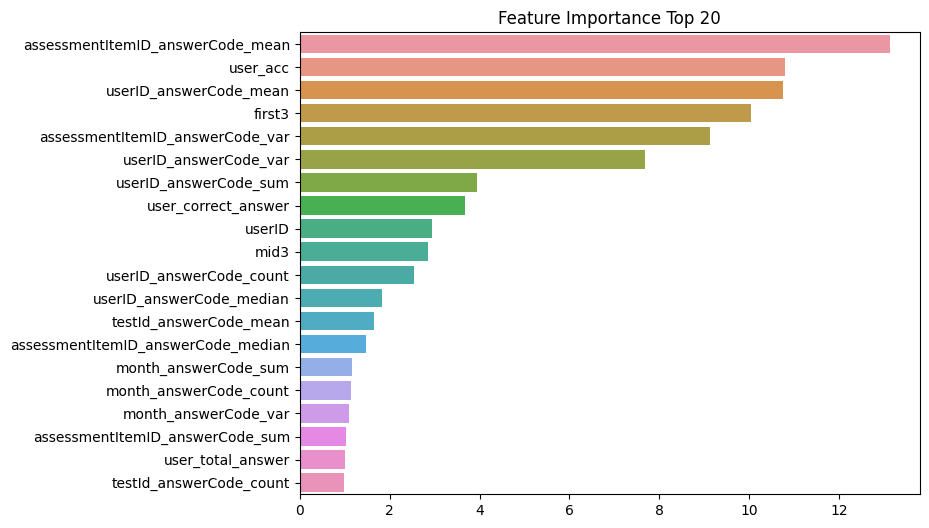

In [9]:
ft_importance_values = model.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = x_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [10]:
x_train.columns

Index(['userID', 'KnowledgeTag', 'userID_answerCode_mean',
       'userID_answerCode_count', 'userID_answerCode_sum',
       'userID_answerCode_var', 'userID_answerCode_median',
       'testId_answerCode_mean', 'testId_answerCode_count',
       'testId_answerCode_sum', 'testId_answerCode_var',
       'testId_answerCode_median', 'assessmentItemID_answerCode_mean',
       'assessmentItemID_answerCode_count', 'assessmentItemID_answerCode_sum',
       'assessmentItemID_answerCode_var', 'assessmentItemID_answerCode_median',
       'KnowledgeTag_answerCode_mean', 'KnowledgeTag_answerCode_count',
       'KnowledgeTag_answerCode_sum', 'KnowledgeTag_answerCode_var',
       'KnowledgeTag_answerCode_median', 'month', 'hour', 'dayofweek',
       'dayofweek_answerCode_mean', 'dayofweek_answerCode_count',
       'dayofweek_answerCode_sum', 'dayofweek_answerCode_var',
       'dayofweek_answerCode_median', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'first3', 'mid3', 'last3',
      

/tmp/ipykernel_114627/109165561.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(x_train.corr())


<AxesSubplot: >

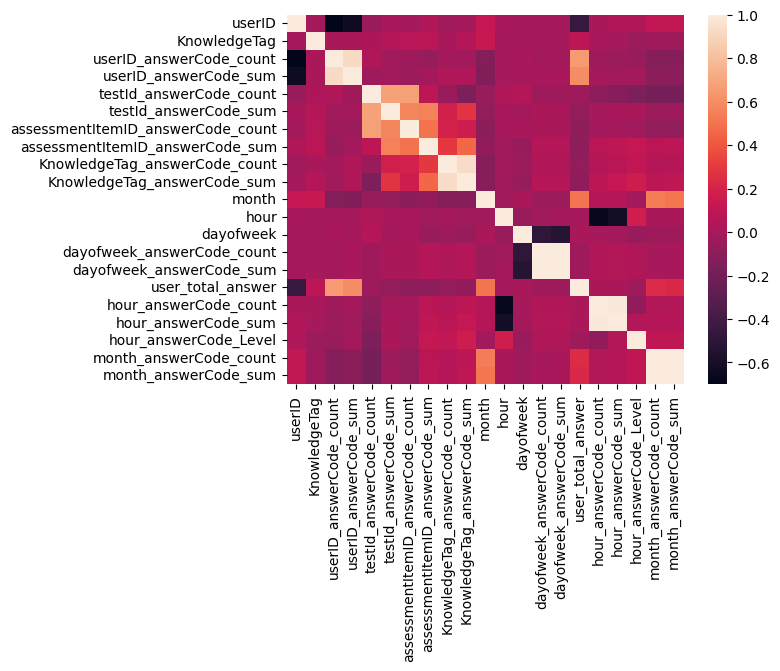

In [11]:
sns.heatmap(x_train.corr())